## Algorithm Overview

The below code provides a simple **gentic algorithm** that attempts to minimize the **2D Schwefel Function** (see figure below). This function is a commonly used benchmark to test metaheuristic methods, as the minimized value is known to be zero, and located at x=y=420.969. Note that the function is defined between +-500 on both the x and y axes.

The genetic algorithm provided here is not overly complex, but provides a baseline from which more complex methods can be applied. The algorithm was implemented as a class, and takes arguments for population size, chromosome dimensions, crossover rate, mutation rate, number of elite solutions, and number of generations to iterate through.

* **popSize**: sets the size of the population, and denotes the number of chromosomes present throughout each generation.
* **dimensions**: sets the number of genes present in each chromosome. Since this problem instance solves the 2D Schwefel function, it is set to two. However, this can be easily changed.
* **crossoverRate**: sets the rate at which crossover occurs between two parent chromosomes. The result of crossover is two children chromosomes.
* **mutationRate**: sets the rate at which mutation occurs in each chromosome. If this happens, a gene is selected at random and set to a random value between +-500.
* **eliteSolutions**: sets the number of elite solutions to be carried from one generation to the next. An elite solution is one of the best solutions found in the parent population.
* **generations**: sets the number of generations that will be iterated through before the algorithm terminates.

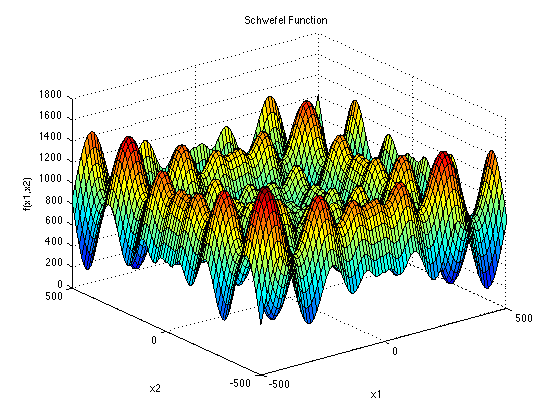

## Importing Libraries

numpy, pandas, math, and random are used throughout the body of the metaheuristic. Time is used to track how long the CPU takes to process the various generations.

In [6]:
import numpy as np
import pandas as pd
import math
import random
import time

## Creating the Genetic Algorithm Class

In [39]:
class geneticAlgorithm():
    def __init__(self, popSize, dimensions, crossoverRate, mutationRate, eliteSolutions, generations):
        self.popSize = popSize
        self.dimensions = dimensions
        self.crossoverRate = crossoverRate
        self.mutationRate = mutationRate
        self.eliteSolutions = eliteSolutions
        self.generations = generations
    
    # _______________________________________________
    # Generating random starting population (parents)
    def createChromosome(self):
        chromosome = [0] * self.dimensions            # Initialize a list to hold the chromosome
        for _ in range(self.dimensions):              # Iterates through the chromosome's dimensions
            chromosome[_] = random.uniform(-500,500)  # Filled with random value between +-500
        return chromosome
    
    def createPop(self):
        pop = [0] * self.popSize              # Initialize a list to hold the population of chromsomes
        for _ in range(self.popSize):         # Iterate through the population's size
            pop[_] = self.createChromosome()  # Fill the population with a randomly generated chromosome      
        return pop
    
    # _______________________________________
    # Create logic for evaluating chromosomes
    def evaluateChromosome(self, chromosome):
        val = 0                                                                 # Initialize a value of zero
        for i in range(self.dimensions):                                        # Iterate through the genes in the chromosome
            val = val + chromosome[i]*math.sin(math.sqrt(abs(chromosome[i])))   # Update the value of the chromosome for each of its genes
        val = 418.9829*self.dimensions - val                                    # Apply last bit of math before returning final value
        return val
    
    def evaluatePopulation(self, population):
        popVals = [0] * self.popSize                             # Initialize a list to hold the population values
        for _ in range(self.popSize):                            # Iterate through each chromosome in the population
            popVals[_] = self.evaluateChromosome(population[_])  # Update the value of each chromosome in the population
        return popVals
    
    # _________________________________
    # Create logic to generate children
    def rouletteWheelSelection(self, population):
        selectionProbs = [0] * self.popSize                                          # Initialize a list to hold the selection probabilities
        summedVals = sum(self.evaluatePopulation(population))                        # Sum all values in the population
        matingPool = [0] * self.popSize                                              # Initialize a mating pool that's the same size as population
        for _ in range(self.popSize):                                                # Iterate through the full population size
            selectionProbs[_] = 1-self.evaluateChromosome(population[_])/summedVals  # Compute the probabilities of selection, lower values are better
        for _ in range(self.popSize):                                                # Iterate through population size
            randomChromosome = random.choices(population, selectionProbs)            # Choose a chromosome based on probabilites computed above
            matingPool[_] = randomChromosome[0]                                      # Add the chromosome to mating pool
        return matingPool
    
    def crossover(self, parentOne, parentTwo):
        crossoverPoint = random.randint(1,self.dimensions-1)                    # Randomly choose a crossover point based on dimensions of chromosomes
        if random.random() < self.crossoverRate:                                # Check if crossover is to occur
            childOne = parentOne[:crossoverPoint] + parentTwo[crossoverPoint:]  # Using crossover point, create child one
            childTwo = parentTwo[:crossoverPoint] + parentOne[crossoverPoint:]  # Using crossover point, create child two
        else:                                                                   # If crossover doesn't occur
            childOne = parentOne                                                # Child one is a copy of parent one
            childTwo = parentTwo                                                # Child two is a copy of parent two
        return childOne, childTwo
        
    def mutate(self, population):
        for _ in range(self.popSize):                                 # Iterate through the entire population size
            if random.random() < self.mutationRate:                   # Check if mutation is to occur
                randomGene = random.randint(0,self.dimensions-1)      # If mutate, select random gene to alter
                population[_][randomGene] = random.uniform(-500,500)  # Replace gene's vlaue with random value between +-500
        return population
    
    # _______________________________________________________________
    # Create logic to insert children and parents into new population
    def insert(self, parents, children):
        nextGeneration = [0] * self.popSize              # Initialize a list to hold the next generation
        parentVals = self.evaluatePopulation(parents)    # Compute the parents' values
        childrenVals = self.evaluatePopulation(children) # Compute the children's values
        
        parentFrame = pd.DataFrame([parents, parentVals]) # Bind the chromosomes and values together
        parentFrame = parentFrame.T                       # Transpose the matrix for easier use
        parentFrame = parentFrame.sort_values(1)          # Sort matrix entries based on values
        
        childrenFrame = pd.DataFrame([children, childrenVals])  # Bind the chromosomes and values together
        childrenFrame = childrenFrame.T                         # Transpose the matrix for easier use
        childrenFrame = childrenFrame.sort_values(1)            # Sort matrix entries based on values
        
        nextGeneration = list(parentFrame[:self.eliteSolutions][0]) + list(childrenFrame[self.eliteSolutions:][0])  # Create the next generation
        return nextGeneration
                
    # ____________________________________________
    # Create logic to run entire genetic algorithm
    def runGenetic(self):
        t0 = time.process_time()                                    # Create variable to hold the computing time
        population = self.createPop()                               # Initizalize a starting population
        for i in range(self.generations):                           # Iterate through all generations (stopping criteria)
            matingPool = self.rouletteWheelSelection(population)    # Create mating pool
            mated = [0] * self.popSize                              # Initizalize a list for mated chromosomes
            for j in range(self.popSize):                           # Iterate through population size
                if j % 2 == 0:                                      # Checks if index is even
                    parentOne = matingPool[j]                       # If even, set to parent one
                    parentTwo = matingPool[j + 1]                   # Sets next chromosome to parent two
                    children = self.crossover(parentOne, parentTwo) # Try crossover given parents
                    mated[j] = children[0]                          # Sets first mated chromosome to first child
                    mated[j+1] = children[1]                        # Sets second mated chromosome to second child
            children = self.mutate(mated)                           # Try mutating children
            population = self.insert(population, children)          # Insert into new population
        procTime = time.process_time() - t0                         # Stop the timer
        bestSolution = population[0]                                # Pulls the best solution
        bestVal = self.evaluateChromosome(bestSolution)             # Evaluates best solution
        return({"BestSolution":bestSolution, "BestValue":bestVal, "ProcessorTime":procTime})
        
    
        

## Testing Algorithm

In [45]:
# Create a class object:
x = geneticAlgorithm(popSize = 100,
                    dimensions = 2,
                    crossoverRate = 0.80,
                    mutationRate = 0.05,
                    eliteSolutions = 10,
                    generations = 1000)

# Call method to run algorithm:
y = x.runGenetic()

# Observe results:
print("Best solution found:", y["BestSolution"])
print("Best value:", y["BestValue"])
print("Processor time to complete (seconds):", y["ProcessorTime"])


Best solution found: [436.5011390841803, 418.84767180129404]
Best value: 30.826693483388794
Processor time to complete (seconds): 11.695929348999925


While the above may produce slightly different outputs each time it is called, the best solution I achieved was [436.501, 418.847], with a value of 30.827. It took my machine 11.696 second to run. Clearly, while this is a basic genetic algorithm it produces near optimal results in a very reasonable time span.